# Mengimpor fungsi library

In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools
import os

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize
from skimage import io 
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.util import random_noise

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

import random

# Menginstal Kaggle di Colab

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rokhiimansarofi","key":"0cfb79c99bf150bbbe869a445ebe88ba"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Mengimpor Dataset Kaggle

In [5]:
!kaggle datasets download -d azaemon/preprocessed-ct-scans-for-covid19

100% 3.58G/3.59G [01:05<00:00, 21.2MB/s]
100% 3.59G/3.59G [01:05<00:00, 58.4MB/s]


In [6]:
!unzip \*.zip  && rm *.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Preprocessed CT scans/nCT/nCT9082.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9083.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9084.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9085.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9086.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9087.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9088.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9089.jpg  
  inflating: Preprocessed CT scans/nCT/nCT909.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9090.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9091.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9092.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9093.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9094.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9095.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9096.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9097.jpg  
  inflating: Preprocessed CT scans/nCT/nC

# Membuat Dataframe untuk Dataset

In [8]:
mypath= 'Original CT Scans/'

file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [9]:
# memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
NiCT    5705
nCT     9979
pCT     4001
dtype: int64

# Membagi Dataset ke dalam Bentuk Train Data dan Test Data

In [10]:
#load library untuk train test split
from sklearn.model_selection import train_test_split

#variabel yang digunakan pada pemisahan data ini
X= df['path']
y= df['tag']

# split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [11]:
# menyatukan kedalam masing-masing dataframe

df_tr = pd.DataFrame({'path':X_train
              ,'tag':y_train
             ,'set':'train'})

df_te = pd.DataFrame({'path':X_test
              ,'tag':y_test
             ,'set':'test'})

In [12]:
print('train size', len(df_tr))
print('test size', len(df_te))

train size 15748
test size 3937


In [13]:
# melihat proporsi pada masing masing set apakah sudah ok atau masih ada yang ingin diubah
df_all = df_tr.append([df_te]).reset_index(drop=1)\

print('===================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('===================================================== \n')

#cek sample datanya
df_all.sample(3)


set    tag 
test   NiCT    1117
       nCT     2051
       pCT      769
train  NiCT    4588
       nCT     7928
       pCT     3232
dtype: int64 




,path,tag,set
9408,Original CT Scans/pCT/pCT2621.jpg,pCT,train
2496,Original CT Scans/pCT/pCT3239.jpg,pCT,train
14040,Original CT Scans/NiCT/NiCT892.jpg,NiCT,train


In [14]:
import shutil
from tqdm.notebook import tqdm as tq
import shutil
import os, sys

# Membuat Folder Baru untuk Dataset

In [15]:
## create folders
os.makedirs('Dataset/')

# Menyalin Dataset ke dalam Folder Dataset Baru

In [16]:
datasource_path = "Original CT Scans/"
dataset_path = "Dataset/"

for index, row in tq(df_all.iterrows()):
    
    #detect filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])            
    
    #make folder destination dirs
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))
    
    #define file dest
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)
    
    #copy file from source to dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

# Pre-processing dan Augmentasi Data

In [18]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split = 0.2,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.1,    
    vertical_flip = True,
    fill_mode = "nearest")

# Mengimpor Dataset

In [19]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
IMAGE_SIZE = 224
BATCH_SIZE = 126
base_dir = os.path.join('Dataset/train/')



train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training',
    class_mode= 'categorical')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation',
    class_mode= 'categorical')

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['NiCT',
          'nCT',
          'pCT',]

for i,label in enumerate(labels):
    folder = os.path.join("Dataset/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 12600 images belonging to 3 classes.
Found 3148 images belonging to 3 classes.
Bentuk array dari dataset train (pelatihan) adalah: (126, 224, 224, 3) (126, 3)
Bentuk array dari dataset validation (validasi) adalah: (126, 224, 224, 3) (126, 3)
Bentuk array dari dataset test (pengujian) adalah: (3937, 224, 224, 3) (3937,)


# Menyimpan label

In [20]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'NiCT': 0, 'nCT': 1, 'pCT': 2}


In [21]:
!cat labels.txt

NiCT
nCT
pCT

# Membuat model CNN

In [22]:
IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

base_model.trainable = False
base_model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________

In [23]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

In [26]:
model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
]
)

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          294944    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 3,523,907
Trainable params: 295,043
Non-trainable params: 3,228,864
_________________________________________________________________


# Melatih Model

In [28]:
history = model.fit_generator(train_generator, 
                    epochs=10, 
                    validation_data=val_generator)

Epoch 1/10
100/100 [==============================] - 253s 3s/step - loss: 0.0573 - acc: 0.9801 - val_loss: 0.1556 - val_acc: 0.9501
Epoch 2/10
100/100 [==============================] - 254s 3s/step - loss: 0.0512 - acc: 0.9821 - val_loss: 0.1195 - val_acc: 0.9632
Epoch 3/10
100/100 [==============================] - 253s 3s/step - loss: 0.0504 - acc: 0.9814 - val_loss: 0.1876 - val_acc: 0.9555
Epoch 4/10
100/100 [==============================] - 265s 3s/step - loss: 0.0497 - acc: 0.9828 - val_loss: 0.1309 - val_acc: 0.9565
Epoch 5/10
100/100 [==============================] - 268s 3s/step - loss: 0.0364 - acc: 0.9872 - val_loss: 0.1467 - val_acc: 0.9597
Epoch 6/10
100/100 [==============================] - 269s 3s/step - loss: 0.0397 - acc: 0.9856 - val_loss: 0.1812 - val_acc: 0.9546
Epoch 7/10
100/100 [==============================] - 270s 3s/step - loss: 0.0342 - acc: 0.9875 - val_loss: 0.1396 - val_acc: 0.9590
Epoch 8/10
100/100 [==============================] - 270s 3s/step - 

# Menampilkan Hasil Pelatihan

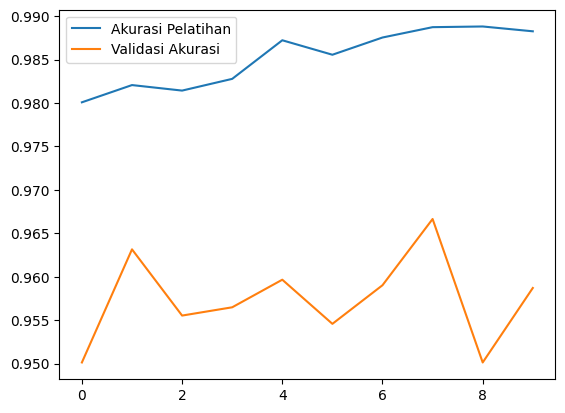

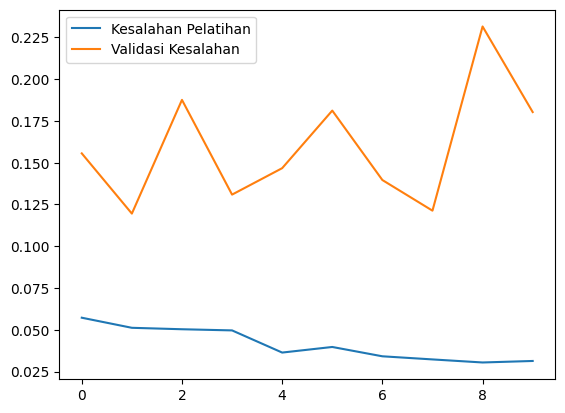

In [29]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

# Memuat Dataset Pengujian

In [30]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

# Mengevaluasi Model

In [31]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 ... 2 2 2]
[0 0 0 ... 2 2 2]


# Menggunakan Model

In [32]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


# Memprediksi Citra Secara Individu

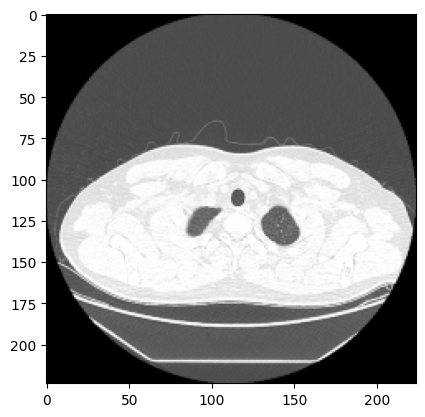

Label yang benar adalah: 0 : NiCT
Nilai yang diprediksi adalah: [9.9961638e-01 3.8347376e-04 9.0421594e-08]
Label yang diprediksi adalah: 0 : NiCT
Prediksi benar


In [33]:
n = 44 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

# Confusion Matrix

Normalized confusion matrix
[[0.98 0.02 0.  ]
 [0.01 0.99 0.01]
 [0.01 0.01 0.98]]


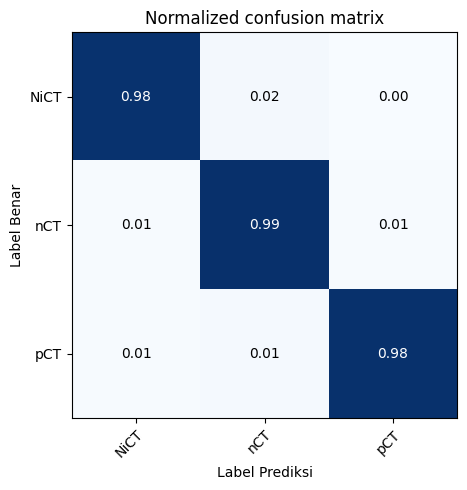

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

# Menyimpan dan mengkonversi Model ke ".tflite"

In [35]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('CTScans_for_Covid19_Classification_MobileNet.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: save/model/assets
